In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.formula.api import ols
import researchpy as rp

#### read in TFBS_bp_covered file

In [3]:
bp_covered = '../../data/promoter_analysis/promoters.bp_covered.txt'

In [4]:
coverage_df = pd.read_table(bp_covered, sep='\t', header=None)
col = ['chr','start','stop','gene','dot','strand','source', 'type', 'dot2', 'details', 'no._of_overlaps', 'no._of_bases_covered','promoter_length','fraction_bases_covered']
coverage_df.columns = col
#add % bases covered column
coverage_df['percentage_bases_covered'] = coverage_df.fraction_bases_covered * 100

#remove unnecessary columns
coverage_df_reduced_columns = coverage_df[['chr','start','stop','gene','strand', 'no._of_overlaps', 'no._of_bases_covered','promoter_length','fraction_bases_covered','percentage_bases_covered']]


In [5]:
coverage_df_reduced_columns

,chr,start,stop,gene,strand,no._of_overlaps,no._of_bases_covered,promoter_length,fraction_bases_covered,percentage_bases_covered
0,1,2630,3630,AT1G01010,+,6,51,1000,0.05100,5.100
1,1,9130,10130,AT1G01020,-,13,83,1000,0.08300,8.300
2,1,10100,11100,AT1G03987,+,41,55,1000,0.05500,5.500
3,1,13714,14714,AT1G01030,-,22,71,1000,0.07100,7.100
4,1,22120,23120,AT1G01040,+,33,135,1000,0.13500,13.500
...,...,...,...,...,...,...,...,...,...,...
33336,mitochondria,361052,362052,ATmitochondriaG01370,-,264,138,1000,0.13800,13.800
33337,mitochondria,361179,362179,ATmitochondriaG01380,-,264,138,1000,0.13800,13.800
33338,mitochondria,362724,363724,ATmitochondriaG01400,+,7,41,1000,0.04100,4.100
33339,mitochondria,363284,364284,ATmitochondriaG01390,-,4,20,1000,0.02000,2.000


In [6]:
#allow colour codes in seaborn
sns.set(color_codes=True)
sns.set_style("whitegrid")

#### Make distribution plot of all gene promoters

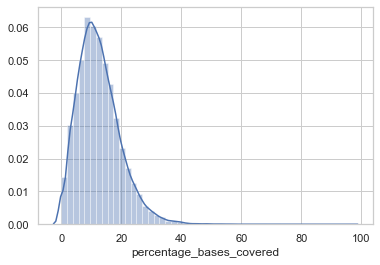

In [7]:
dist_plot = coverage_df_reduced_columns['percentage_bases_covered']
#create figure with no transparency
dist_plot_fig = sns.distplot(dist_plot).get_figure()

#save to file
dist_plot_fig.savefig('../../data/plots/TFBS_coverage/all_genes_bp_covered_dist.pdf', format='pdf')


### constitutive vs responsive genes

In [8]:
responsive_bp_covered = '../../data/promoter_analysis/responsivepromoters.bp_covered.txt'

In [9]:
coverage_df2 = pd.read_table(responsive_bp_covered, sep='\t', header=None)
col = ['chr','start','stop','gene','dot','strand','source', 'type', 'dot2', 'details', 'no._of_overlaps', 'no._of_bases_covered','promoter_length','fraction_bases_covered']
coverage_df2.columns = col
#add % bases covered column
coverage_df2['percentage_bases_covered'] = coverage_df2.fraction_bases_covered * 100

#remove unnecessary columns
coverage_df2_reduced_columns = coverage_df2[['chr','start','stop','gene','strand', 'no._of_overlaps', 'no._of_bases_covered','promoter_length','fraction_bases_covered','percentage_bases_covered']]

#### add promoter type column

In [10]:
select_genes_file = '../../data/genomes/ara_housekeeping_list.out'
select_genes = pd.read_table(select_genes_file, sep='\t', header=None)
cols = ['gene','gene_type']
select_genes.columns = cols
merged = pd.merge(coverage_df2_reduced_columns, select_genes, on='gene' )

In [11]:
merged

,chr,start,stop,gene,strand,no._of_overlaps,no._of_bases_covered,promoter_length,fraction_bases_covered,percentage_bases_covered,gene_type
0,1,33171,34171,AT1G01050,-,7,73,1000,0.073,7.3,randCont
1,1,281760,282760,AT1G01780,+,119,154,1000,0.154,15.4,highVar
2,1,316090,317090,AT1G01910,-,25,122,1000,0.122,12.2,housekeeping
3,1,344515,345515,AT1G02000,+,8,90,1000,0.090,9.0,highVar
4,1,728829,729829,AT1G03070,+,101,121,1000,0.121,12.1,highVar
...,...,...,...,...,...,...,...,...,...,...,...
401,5,26120581,26121581,AT5G65360,-,8,82,1000,0.082,8.2,randCont
402,5,26171008,26172008,AT5G65470,+,6,71,1000,0.071,7.1,randCont
403,5,26467531,26468531,AT5G66250,+,1,14,1000,0.014,1.4,randCont
404,5,26817948,26818948,AT5G67210,+,20,161,1000,0.161,16.1,highVar


#### scatterplots

In [12]:
#set style to ticks
sns.set(style="ticks", color_codes=True)

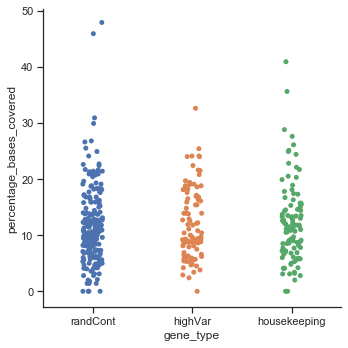

In [13]:
sns.catplot(x="gene_type", y="percentage_bases_covered", data=merged).savefig('../../data/plots/TFBS_coverage/responsive_bp_covered.pdf', format='pdf')


##### it looks like there is no difference!

#### boxplot

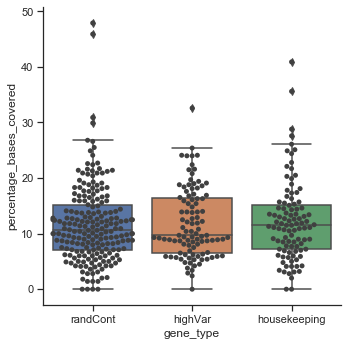

In [14]:
sns.catplot(x="gene_type", y="percentage_bases_covered", kind='box', data=merged)
#plot points
ax = sns.swarmplot(x="gene_type", y="percentage_bases_covered", data=merged, color=".25").get_figure().savefig('../../data/plots/TFBS_coverage/responsive_bp_covered_boxplot.pdf', format='pdf')

#### violin plot

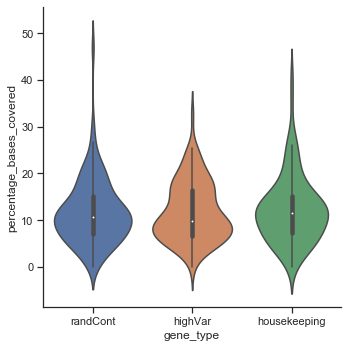

In [15]:
sns.catplot(x="gene_type", y="percentage_bases_covered", kind='violin', data=merged).savefig('../../data/plots/TFBS_coverage/responsive_bp_covered_violinplot.pdf', format='pdf')


### stats

###group_by gene type

In [16]:
groupby_genetype = merged.groupby('gene_type')
for type, value in groupby_genetype['percentage_bases_covered']:
    print((type, value.mean()))

('highVar', 11.82)
('housekeeping', 12.235999999999999)
('randCont', 11.683980582524272)


In [17]:
groupby_genetype.mean()

,chr,start,stop,no._of_overlaps,no._of_bases_covered,promoter_length,fraction_bases_covered,percentage_bases_covered
gene_type,,,,,,,,
highVar,3.000000,1.133520e+07,1.133620e+07,37.710000,118.200000,1000.0,0.11820,11.820000
housekeeping,2.790000,1.278677e+07,1.278777e+07,35.900000,122.360000,1000.0,0.12236,12.236000
randCont,2.907767,1.255818e+07,1.255918e+07,43.184466,116.839806,1000.0,0.11684,11.683981


#### normality test (based on D’Agostino and Pearson’s test)

In [18]:
stat, p = stats.normaltest(merged['percentage_bases_covered'])
print('Statistics%.3f, p=%.3f' % (stat, p))

Statistics112.137, p=0.000


In [19]:
alpha = 0.05
# null hypothesis: x comes from a normal distributionprint
if p < alpha:
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")

The null hypothesis can be rejected


#### data is not normal

### test variance

In [20]:
#create linear model of gene type by %bases_covered
model = ols('percentage_bases_covered ~ gene_type', merged).fit()

In [21]:
#summary
print(model.summary())

                               OLS Regression Results                               
Dep. Variable:     percentage_bases_covered   R-squared:                       0.001
Model:                                  OLS   Adj. R-squared:                 -0.004
Method:                       Least Squares   F-statistic:                    0.2192
Date:                      Sun, 24 Nov 2019   Prob (F-statistic):              0.803
Time:                              11:15:39   Log-Likelihood:                -1356.8
No. Observations:                       406   AIC:                             2720.
Df Residuals:                           403   BIC:                             2732.
Df Model:                                 2                                         
Covariance Type:                  nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------

### descriptive stats

In [22]:
merged.groupby(['gene_type'])['percentage_bases_covered'].describe()

,count,mean,std,min,25%,50%,75%,max
gene_type,,,,,,,,
highVar,100.0,11.820000,6.248766,0.0,6.575,9.7,16.35,32.6
housekeeping,100.0,12.236000,7.202153,0.0,7.200,11.5,15.15,40.9
randCont,206.0,11.683981,6.982905,0.0,7.100,10.6,15.15,47.9


### make separate dfs based on gene_type

In [23]:
constitutive = merged[merged.gene_type == 'highVar']
#reset indexes so residuals can be calculated later
constitutive.reset_index(inplace=True)

responsive = merged[merged.gene_type == 'housekeeping']
responsive.reset_index(inplace=True)

control = merged[merged.gene_type == 'randCont']
control.reset_index(inplace=True)

In [24]:
#### test Homogeneity of variances

In [25]:
print(stats.levene(constitutive.percentage_bases_covered, responsive.percentage_bases_covered))

LeveneResult(statistic=0.10045933531478, pvalue=0.751613050777689)


#### not significant meaning there is homogeneity of variances and we can proceed

### Normal distribution of residuals

##### The residuals needs to be normally distributed. To calculate the residuals between the groups, subtract the values of one group from the values of the other group.

In [26]:
diff = constitutive.percentage_bases_covered - responsive.percentage_bases_covered

#### pplot

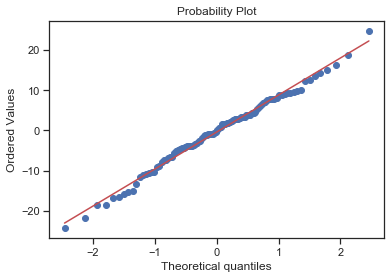

In [27]:
stats.probplot(diff, plot= plt);

### histogram

## normality of residuals

In [28]:
W_test_stat, p_value = stats.shapiro(diff)

In [29]:
W_test_stat, p_value

(0.992019772529602, 0.8226550221443176)

In [30]:
### not significant p_value so data is normally distributed

In [31]:
stat, p = stats.normaltest(diff)
print('Statistics%.3f, p=%.3f' % (stat, p))

Statistics0.900, p=0.638


In [32]:
alpha = 0.05
# null hypothesis: x comes from a normal distributionprint
if p < alpha:
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")

The null hypothesis cannot be rejected


### not significant p_value so data is normally distributed

## independent samples T-test

In [33]:
stats.ttest_ind(constitutive.percentage_bases_covered, responsive.percentage_bases_covered)

Ttest_indResult(statistic=-0.43628289991175434, pvalue=0.6631068221116974)

#### use researchpy to get degrees of freedom, the difference between the groups mean, and a measure of effect size

In [34]:
descriptives, results = rp.ttest(constitutive.percentage_bases_covered, responsive.percentage_bases_covered)
descriptives

,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,percentage_bases_covered,100.0,11.820,6.248766,0.624877,10.580109,13.059891
1,percentage_bases_covered,100.0,12.236,7.202153,0.720215,10.806937,13.665063
2,combined,200.0,12.028,6.728602,0.475784,11.089775,12.966225


In [35]:
results

,Independent t-test,results
0,Difference (percentage_bases_covered - percent...,-0.4160
1,Degrees of freedom =,198.0000
2,t =,-0.4363
3,Two side test p value =,0.6631
4,Difference > 0 p value =,0.3316
5,Difference < 0 p value =,0.6684
6,Cohen's d =,-0.0617
7,Hedge's g =,-0.0615
8,Glass's delta =,-0.0666
9,r =,0.0310


## not a statistcally significant difference between constitutive and responsive promoter percentage_bases_covered

# <b> include random sample

#### get names of each promoter type for later

In [36]:
pd.Categorical(merged.gene_type)

[randCont, highVar, housekeeping, highVar, highVar, ..., randCont, randCont, randCont, highVar, randCont]
Length: 406
Categories (3, object): [highVar, housekeeping, randCont]

In [37]:
names = merged.gene_type.unique()

In [38]:
print(merged.dtypes)

chr                           int64
start                         int64
stop                          int64
gene                         object
strand                       object
no._of_overlaps               int64
no._of_bases_covered          int64
promoter_length               int64
fraction_bases_covered      float64
percentage_bases_covered    float64
gene_type                    object
dtype: object


In [39]:
for name in names:
    print(name)

randCont
highVar
housekeeping


#### tet normality

In [40]:
#returns test statistic, p-value
for name in names:
    print('{}: {}'.format(name, stats.shapiro(merged.percentage_bases_covered[merged.gene_type == name])))

randCont: (0.9072531461715698, 4.875971293394343e-10)
highVar: (0.9494914412498474, 0.0007681143470108509)
housekeeping: (0.9271503686904907, 3.442267552600242e-05)


### normality rejected for highvar category



### q-plots - constitutive

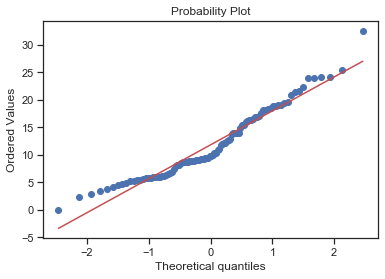

In [41]:
stats.probplot(constitutive.percentage_bases_covered, plot= plt);

### q-plots - responsive

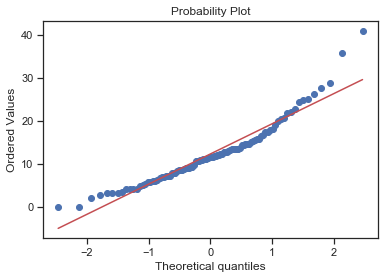

In [42]:
stats.probplot(responsive.percentage_bases_covered, plot= plt);

### q-plots - random control

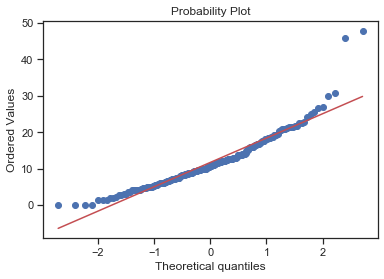

In [43]:
stats.probplot(control.percentage_bases_covered, plot= plt);

## test homoscedasticity (Homogeneity of Variance)

In [44]:
stats.levene(merged.percentage_bases_covered[merged.gene_type == names[0]], 
               merged.percentage_bases_covered[merged.gene_type == names[1]], 
               merged.percentage_bases_covered[merged.gene_type == names[2]])

LeveneResult(statistic=0.05549966805194884, pvalue=0.9460195669673873)

#### fail to reject null hypothesis that variances are equal

## need to use Kruskal-Wallis one way analysis of variance: scipy.stats.kruskal

In [45]:
stats.kruskal(merged.percentage_bases_covered[merged.gene_type == names[0]], 
               merged.percentage_bases_covered[merged.gene_type == names[1]], 
               merged.percentage_bases_covered[merged.gene_type == names[2]])

KruskalResult(statistic=0.3717078442574983, pvalue=0.8303948884401728)

In [46]:
#variable vs housekeeping
stats.mannwhitneyu(merged.percentage_bases_covered[merged.gene_type == names[1]], 
               merged.percentage_bases_covered[merged.gene_type == names[2]])

MannwhitneyuResult(statistic=4895.0, pvalue=0.3992279691550435)

## not significantly different